In [185]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import os
import zipfile
import scipy
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score, roc_auc_score, r2_score
from theano import tensor as tt
from theano import shared

%matplotlib inline

In [186]:
if not os.path.isfile('../../data/osha/osha_norm_naics.csv'):
    with zipfile.ZipFile('../../data/osha/osha_norm_naics.zip','r') as zfile:
        zfile.extractall('../../data/osha')
osha = pd.read_csv('../../data/osha/osha_norm_naics.csv', dtype={'naics_code':str, 'sic_code':str},
                  na_values = ["", " ","NaN", "nan", "NA", "na", "Na"])
osha = osha[['date_sampled','inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name', 'subsector_name',
             'industry_group_name', 'conc_mgm3']]  # keep only cols we need
osha['date_sampled'] = osha['date_sampled'].str.slice(0,4).astype(int)
osha = osha[~osha['sector_name'].isin(["Undefined/Multiple"])]
osha = osha.drop(osha[osha['conc_mgm3']>10000].index)
osha = osha.dropna(subset=['conc_mgm3', 'sector_name'])
osha['detected'] = np.where(osha['conc_mgm3'] > 0, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,7,11,20,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0, 0.5, '# of samples')

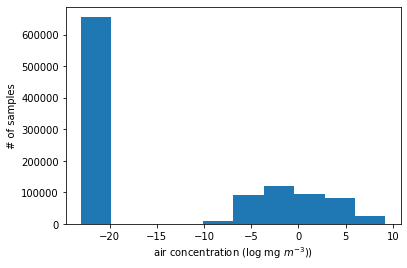

In [187]:
plt.hist(np.log(osha['conc_mgm3']+0.0000000001))
plt.xlabel('air concentration (log mg $m^{-3})$)')
plt.ylabel('# of samples')

In [188]:
osha = osha.groupby(['inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name',
                     'subsector_name', 'industry_group_name'], as_index=False).max(numeric_only=True)
osha.head(6)

,inspection_number,establishment_name,preferred_name,naics_unified,sector_name,subsector_name,industry_group_name,date_sampled,conc_mgm3,detected
0,29067,"GARMAT USA, INC.",Iron oxide,332322,Manufacturing,Fabricated Metal Product Manufacturing,Architectural and Structural Metals Manufacturing,2011,1.959734,1
1,29206,Polar Corporation,Iron oxide,811310,Other Services,Repair and Maintenance,Commercial and Industrial Machinery and Equipm...,2011,12.966245,1
2,29251,"Jobsite, Inc.",Iron oxide,333517,Manufacturing,Machinery Manufacturing,Metalworking Machinery Manufacturing,2011,0.519814,1
3,29479,"TIC, The Industrial Company",Iron oxide,236210,Construction,Construction of Buildings,Nonresidential Building Construction,2011,0.080790,1
4,63156,Nomad Global Communication Solutions,Iron oxide,334290,Manufacturing,Computer and Electronic Product Manufacturing,Communications Equipment Manufacturing,2011,3.093908,1
5,63259,"PRECISION PLATING COMPANY, INC.",Iron oxide,332813,Manufacturing,Fabricated Metal Product Manufacturing,"Coating, Engraving, Heat Treating, and Allied ...",2011,0.000000,0


In [189]:
len(osha)

233975

In [372]:
opera = pd.read_csv('../../data/osha/chemical_metadata/opera2_physical.csv')
opera

,PREFERRED_NAME,MoleculeID,LogP_pred,MP_pred,BP_pred,LogVP_pred,LogWS_pred,LogHL_pred,RT_pred,LogKOA_pred,LogD55_pred,LogD74_pred,LogOH_pred,LogKoc_pred
0,"1,1,1,2-Tetrafluoroethane",DTXSID1021324,0.827040,-102.840618,-22.605931,3.539329,-2.918477,-1.308825,1.077754,0.036410,0.827040,0.827040,-14.241688,1.602622
1,"1,1,1-Trichloro-2,2,2-trifluoroethane",DTXSID5027148,2.577394,-15.002823,48.806711,2.765054,-2.226180,-0.825878,11.526084,2.294088,2.577394,2.577394,-15.276176,1.861776
2,"1,2-Difluoro-1,1,2,2-tetrachloroethane",DTXSID5026091,3.042323,24.586119,91.183236,1.878533,-3.075882,-0.782740,12.076823,3.710297,3.042323,3.042323,-14.523127,1.994880
3,"1,1,2,2-Tetrachloroethane",DTXSID7021318,2.350099,-39.864348,147.582052,0.862776,-1.754303,-3.300416,10.683509,3.464204,2.350099,2.350099,-12.884900,1.894347
4,"1,1,2-Trichloro-1,2,2-trifluoroethane",DTXSID6021377,2.966338,-44.225351,50.560073,2.682974,-2.994329,-1.081953,8.322817,2.818690,2.966338,2.966338,-15.292594,1.861775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,4-Vinyl-1-cyclohexene dioxide,DTXSID0020604,0.670876,75.401822,221.813643,-1.583812,-0.246298,-4.695892,6.542498,4.306213,0.670876,0.670876,-10.711082,1.762055
729,"1,1-Dichloroethylene",DTXSID8021438,2.146029,-92.054831,41.134842,2.521820,-1.435674,-2.074198,0.000000,2.597997,2.146029,2.146029,-10.958900,1.780304
730,Oxamyl,DTXSID6021086,-0.537842,100.495968,306.162430,-3.848174,-0.203799,-9.882354,2.713181,9.225506,-0.540338,-0.537873,-11.234750,1.099346
731,Warfarin,DTXSID5023742,2.688832,162.602197,398.372135,-7.143559,-4.253120,-8.942250,16.801856,10.660081,2.688832,2.688832,-10.475345,2.965329


In [373]:
opera = opera.drop(columns=['MoleculeID'])
#chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
opera.columns = [x.lower() for x in opera.columns]
opera_cols =  opera.columns[1:]
opera_s = opera.copy()
opera_s[opera_cols] =  scale(opera_s[opera_cols])  # center and scale opera predictors

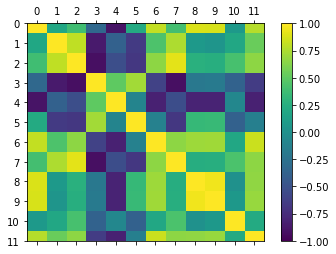

In [374]:
correlations = opera_s.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,12,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

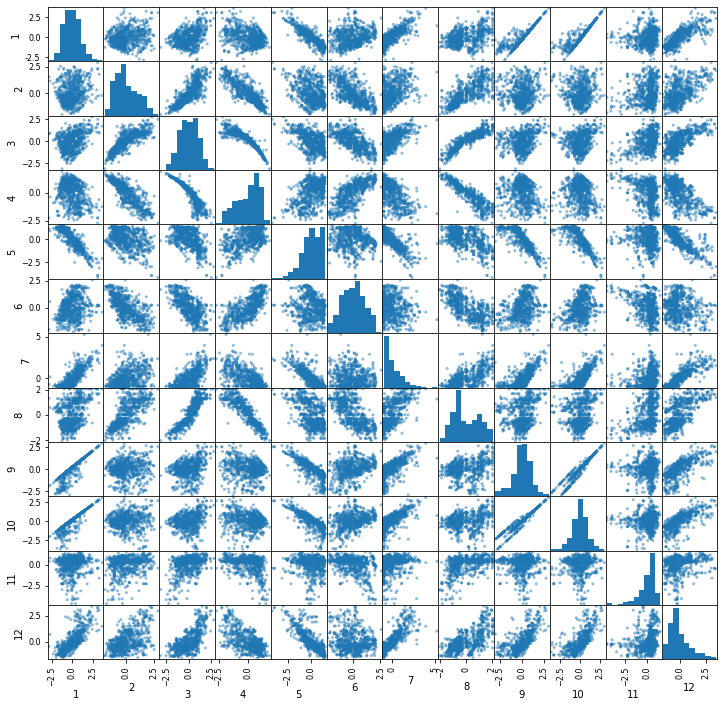

In [375]:
opera_s_plot = opera_s.copy()
opera_s_plot.columns = np.arange(0,13,1)
pd.plotting.scatter_matrix(opera_s_plot, figsize=(12,12))
plt.show()

In [194]:
for i, var in enumerate(opera_cols):
    print('beta {}: {}'.format(i,var))

beta 0: logp_pred
beta 1: mp_pred
beta 2: bp_pred
beta 3: logvp_pred
beta 4: logws_pred
beta 5: loghl_pred
beta 6: rt_pred
beta 7: logkoa_pred
beta 8: logd55_pred
beta 9: logd74_pred
beta 10: logoh_pred
beta 11: logkoc_pred


In [195]:
opera_s = opera_s.drop(columns=['logkoa_pred','mp_pred', 'logd55_pred','logd74_pred']) # drop highly correlated predictors
opera_cols = opera_s.columns.tolist()
opera_cols.remove('preferred_name')
opera_cols_med = ['log octanol-water partition coefficient','boiling point', 'log vapor pressure', 'log water solubility', "log henry's law constant",
                 'HPLC retention time', 'log OH rate constant', 'log soil adsorption coefficient']


chem_osha = osha.merge(opera_s, left_on='preferred_name', right_on='preferred_name')
chem_osha = chem_osha.dropna(subset=opera_cols)  # drop rows missing opera predictions
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 91)

In [252]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

indexed_osha_full = indexed_osha.copy()
indexed_osha_test = indexed_osha[indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015'])]  # training/test dataset split by year
indexed_osha = indexed_osha[~(indexed_osha['date_sampled'].isin(['1990','1995','2005' '2015']))]

In [199]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

detected_shared = shared(indexed_osha.detected.values)
preds_shared = shared(preds.values)
index_s_shared = shared(indexed_osha.index_s.values)
index_ss_shared = shared(indexed_osha.index_ss.values)

# define our Bayesian hierarchical logistic model in pymc3
with pm.Model() as osha_logistic_physical:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[index_ss_shared] + tt.dot(preds_shared,beta)
    
    θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Bernoulli(
        'likelihood',
        p = θ,
        observed=detected_shared
    )

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


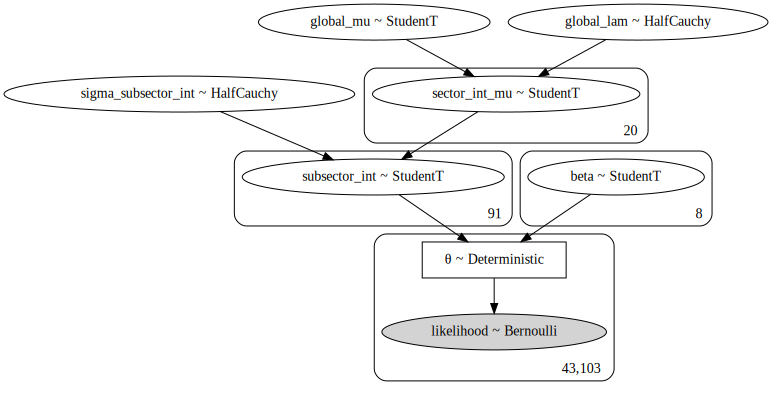

In [200]:
from pymc3 import model_to_graphviz

model_to_graphviz(osha_logistic_physical)

In [201]:
with osha_logistic_physical:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])
#fit = fr_advi.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(), tracker])


  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple seq

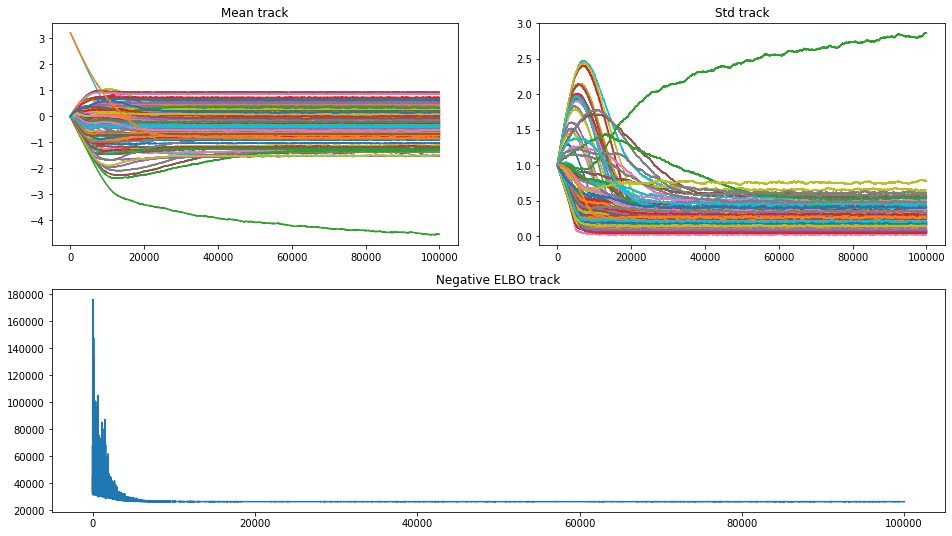

In [202]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


<Figure size 432x1152 with 0 Axes>

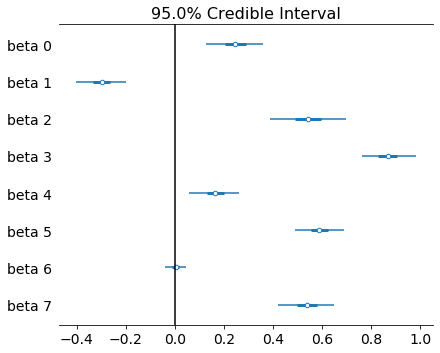

In [384]:
plt.figure(figsize=(6,16))
pm.forestplot(fit.sample(1000), var_names=['beta'], credible_interval=0.95)
plt.axvline(x=0, color='black')

In [204]:
for i, var in enumerate(opera_cols_med):
    print('beta {}: {}'.format(i,var))

beta 0: log octanol-water partition coefficient
beta 1: boiling point
beta 2: log vapor pressure
beta 3: log water solubility
beta 4: log henry's law constant
beta 5: HPLC retention time
beta 6: log OH rate constant
beta 7: log soil adsorption coefficient


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


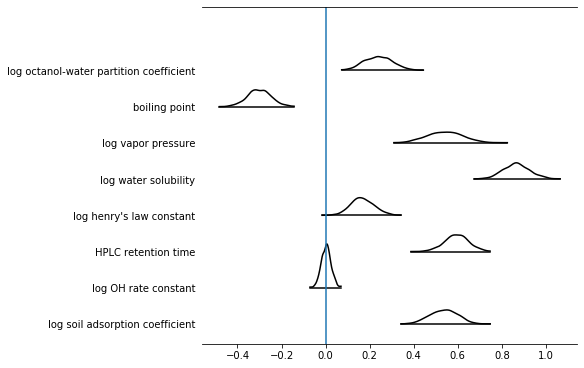

In [205]:
fig, axes = pm.forestplot(fit.sample(1000), kind='ridgeplot', var_names=['beta'], ridgeplot_overlap=3, colors='white', figsize=(8,5))
fig.axes[0].set_yticklabels(opera_cols_med[::-1])
plt.axvline(x=0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


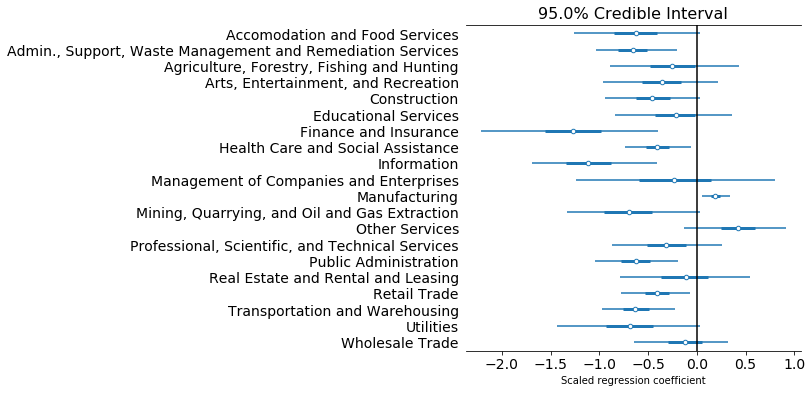

In [385]:
sector_index.loc[1,'sector_name'] = "Admin., Support, Waste Management and Remediation Services"  # make sector label shorter
fig, axes = pm.forestplot(fit.sample(1000), var_names=['sector_int_mu'], credible_interval=0.95)
fig.axes[0].set_yticklabels(sector_index['sector_name'][::-1])
fig.axes[0].set_xlabel("Scaled regression coefficient")
plt.axvline(x=0, color='black')

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


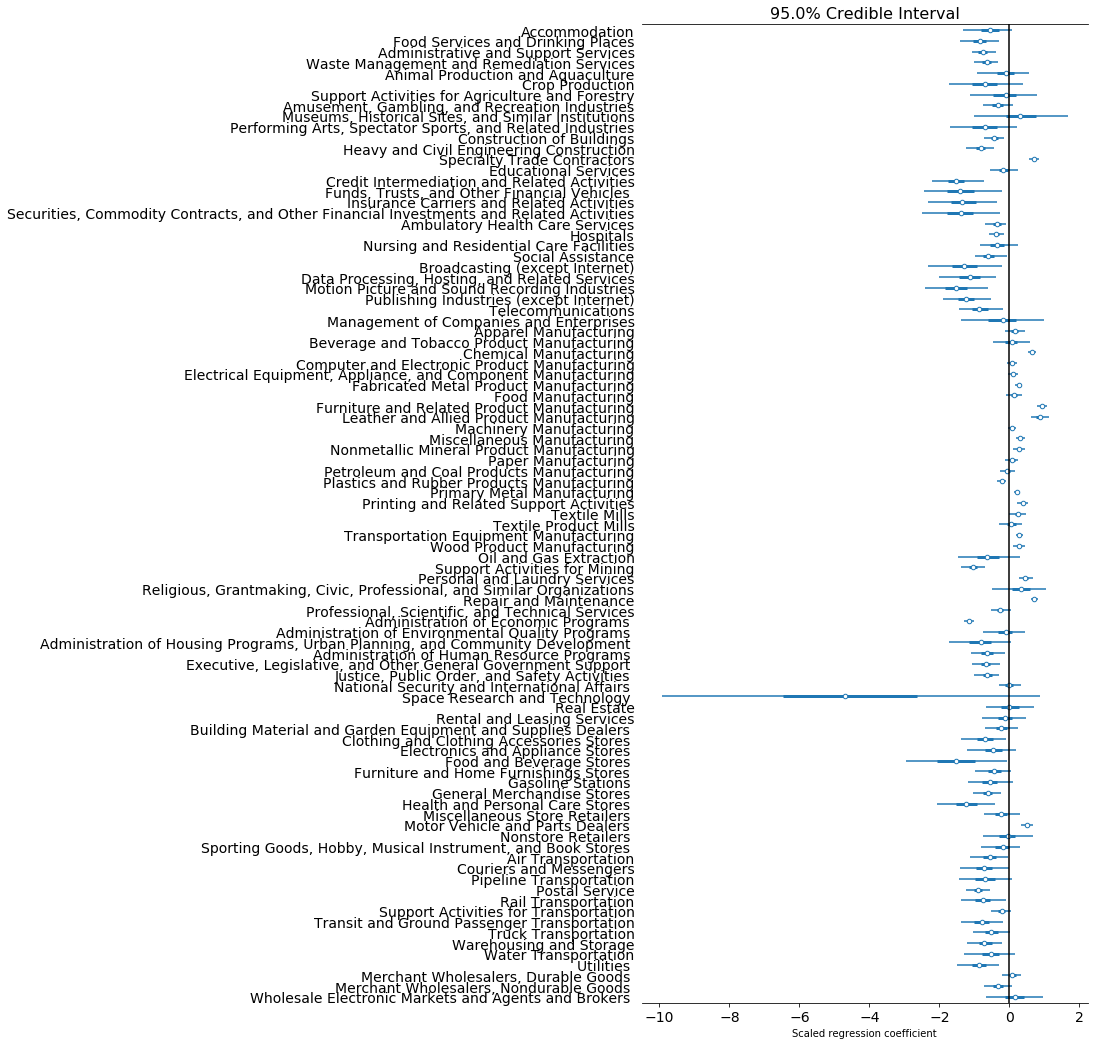

In [387]:
fig, axs = pm.forestplot(fit.sample(1000), var_names=['subsector_int'], figsize=(8,18), credible_interval=0.95)
fig.axes[0].set_yticklabels(sector_subsector_index['subsector_name'][::-1])
fig.axes[0].set_xlabel("Scaled regression coefficient")
plt.axvline(x=0, color='black')

In [211]:
#pm.plot_posterior(fit.sample(1000), var_names=['beta'])

### Find an exact solution with Hamiltonian MC (takes much longer, very similar result)

In [212]:
#with hierarchical_logistic_osha_2:
#    hmc = pm.sample(4000)

In [213]:
#pm.gelman_rubin(hmc)

In [214]:
#pm.traceplot(hmc, var_names=['subsector_int']);

In [215]:
#pm.traceplot(hmc,var_names = ['beta'])

In [216]:
#pm.forestplot(hmc, var_names = ['beta','sector_int_mu', 'subsector_int'], combined=True)

## Posterior predictive checks

#### Average across 500 sets of probablistic predictions

In [217]:
ppc = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_physical)
avg_predictions = np.where(ppc['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:07<00:00, 66.22it/s]


#### Classification accuracy metrics

In [218]:
accuracy = accuracy_score(avg_predictions, indexed_osha['detected'])
auc = roc_auc_score(avg_predictions, indexed_osha['detected'])
null_predictions = np.where(np.random.uniform(size=len(indexed_osha['detected'])) >
                                        indexed_osha['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions,indexed_osha['detected'])
null_auc = roc_auc_score(null_predictions, indexed_osha['detected'])

print('Training classification accuracy: {:.2f}'.format(accuracy))
print('Null model training classification accuracy: {:.2f}'.format(null_accuracy))
print('Training ROC area under the curve: {:.2f}'.format(auc))
print('Null model training ROC area under the curve: {:.2f}'.format(null_auc))

Training classification accuracy: 0.68
Training ROC area under the curve: 0.67


#### Actual vs predicted subsector detection frequency

In [382]:
subsector_probs = indexed_osha[['detected', 'index_ss']].copy()
subsector_probs['prob_predicted'] = avg_predictions
subsector_probs = subsector_probs.groupby('index_ss').mean()
subsector_counts = indexed_osha['index_ss'].value_counts()
#subsector_probs = subsector_probs[subsector_counts > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs['detected'], subsector_probs['prob_predicted'])[0,1]

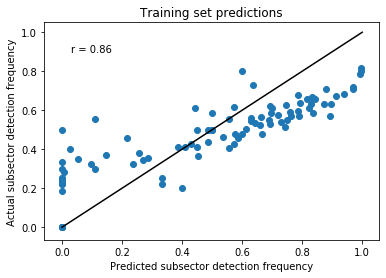

In [383]:
plt.scatter( subsector_probs['prob_predicted'], subsector_probs['detected'])
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.title('Training set predictions')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

#### Test set accuracy

In [222]:
preds_test = indexed_osha_test[opera_cols]
detected_shared.set_value(indexed_osha_test.detected.values)
preds_shared.set_value(preds_test.as_matrix())
index_s_shared.set_value(indexed_osha_test.index_s.values)
index_ss_shared.set_value(indexed_osha_test.index_ss.values)

ppc_test = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_physical)
avg_predictions_test = np.where(ppc_test['likelihood'].mean(axis=0) >= 0.5, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 500/500 [00:05<00:00, 98.68it/s]


In [223]:
accuracy = accuracy_score(avg_predictions_test, indexed_osha_test['detected'])
null_predictions_test = np.where(np.random.uniform(size=len(indexed_osha_test['detected'])) >
                                        indexed_osha_test['detected'].mean(),1,0)
null_accuracy = accuracy_score(null_predictions_test,indexed_osha_test['detected'])
auc = roc_auc_score(avg_predictions_test, indexed_osha_test['detected'])
null_auc = roc_auc_score(null_predictions_test, indexed_osha_test['detected'])
print('Test classification accuracy: {:.2f}'.format(accuracy))
print('Null model test classification accuracy: {:.2f}'.format(null_accuracy))
print('Test ROC area under the curve: {:.2f}'.format(auc))
print('Null model test ROC area under the curve: {:.2f}'.format(null_auc))


Test classification accuracy: 0.69
Null model test classification accuracy: 0.46
Test ROC area under the curve: 0.67
Null model test ROC area under the curve: 0.50


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


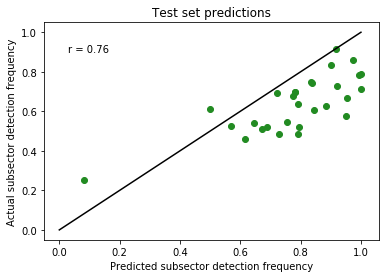

In [380]:
subsector_probs_test = indexed_osha_test[['detected', 'index_ss']].copy()
subsector_probs_test['prob_predicted'] = avg_predictions_test
subsector_probs_test = subsector_probs_test.groupby('index_ss').mean()
subsector_counts_test = indexed_osha_test['index_ss'].value_counts()
subsector_probs_test = subsector_probs_test[subsector_counts_test > 10] # drop subsectors with very few data points
r = np.corrcoef(subsector_probs_test['detected'], subsector_probs_test['prob_predicted'])[0,1]

plt.scatter(subsector_probs_test['prob_predicted'], subsector_probs_test['detected'], color='forestgreen')
plt.plot([0, 1], [0, 1], color='black')
plt.xlabel('Predicted subsector detection frequency')
plt.ylabel('Actual subsector detection frequency')
plt.title('Test set predictions')
plt.text(0.03, 0.9, 'r = {:.2f}'.format(r))
plt.show()

## Predictions using all data

In [257]:
preds_full = indexed_osha_full[opera_cols]
detected_shared.set_value(indexed_osha_full.detected.values)
preds_shared.set_value(preds_full.as_matrix())
index_s_shared.set_value(indexed_osha_full.index_s.values)
index_ss_shared.set_value(indexed_osha_full.index_ss.values)

ppc_full = pm.sample_posterior_predictive(fit.sample(1000), samples= 500, model=osha_logistic_physical) # rows = 500 model predictions, cols = 45800 osha samples
avg_predictions_full = np.where(ppc_full['likelihood'].mean(axis=0) >= 0.5, 1, 0)  # collapse all 500 model predictions into one mean prediction

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 500/500 [00:09<00:00, 54.76it/s]


In [342]:
predictions_full = pd.DataFrame(ppc_full['likelihood'].transpose())  # keep all 500 model predictions to preserve variability; transpose to 45800 x 500
predictions_full['sector_name'] = indexed_osha_full['sector_name']
predictions_full['subsector_name'] = indexed_osha_full['subsector_name']
sector_probs = predictions_full.groupby('sector_name',axis=0).mean()
subsector_probs = predictions_full.groupby('subsector_name',axis=0).mean()

# calculate median, 2.5 and 97.5% PIs
sector_median = sector_probs.quantile(axis=1,q=0.5)
sector_95h = sector_probs.quantile(axis=1,q=0.975)
sector_95l = sector_probs.quantile(axis=1,q=0.025)
subsector_median = subsector_probs.quantile(axis=1,q=0.5)
subsector_95h = subsector_probs.quantile(axis=1,q=0.975)
subsector_95l = subsector_probs.quantile(axis=1,q=0.025)

# order for plotting
sector_order = sector_median.sort_values(ascending=True)
subsector_order = subsector_median.sort_values(ascending=True)

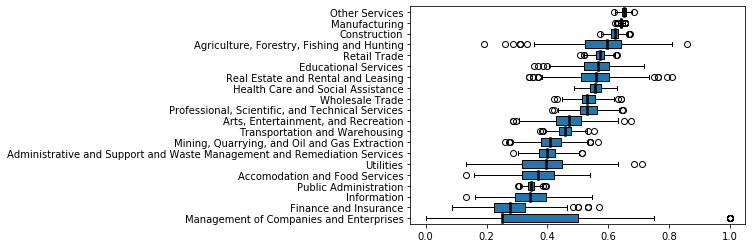

In [324]:
medianprops = dict(linestyle='-', linewidth=2.5, color='black')
sector_plot = plt.boxplot(sector_probs.loc[sector_order.index],vert=False, patch_artist=True, labels=sector_probs.loc[sector_order.index].index,
                          widths=0.75, medianprops=medianprops)
#plt.figure(figsize=(20,20))
plt.show()

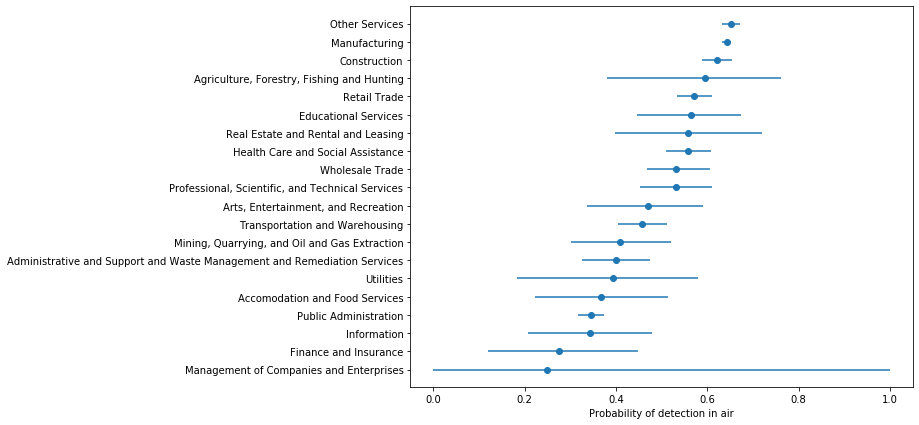

In [361]:
error_95_upper = (sector_95h-sector_median).loc[sector_order.index]
error_95_lower = (sector_median-sector_95l).loc[sector_order.index]
plt.figure(figsize=(9,7))
plt.errorbar(x=sector_median.loc[sector_order.index], y=sector_order.index,
             xerr=(error_95_lower, error_95_upper),
            fmt='o')
plt.xlabel('Probability of detection in air')
plt.show()

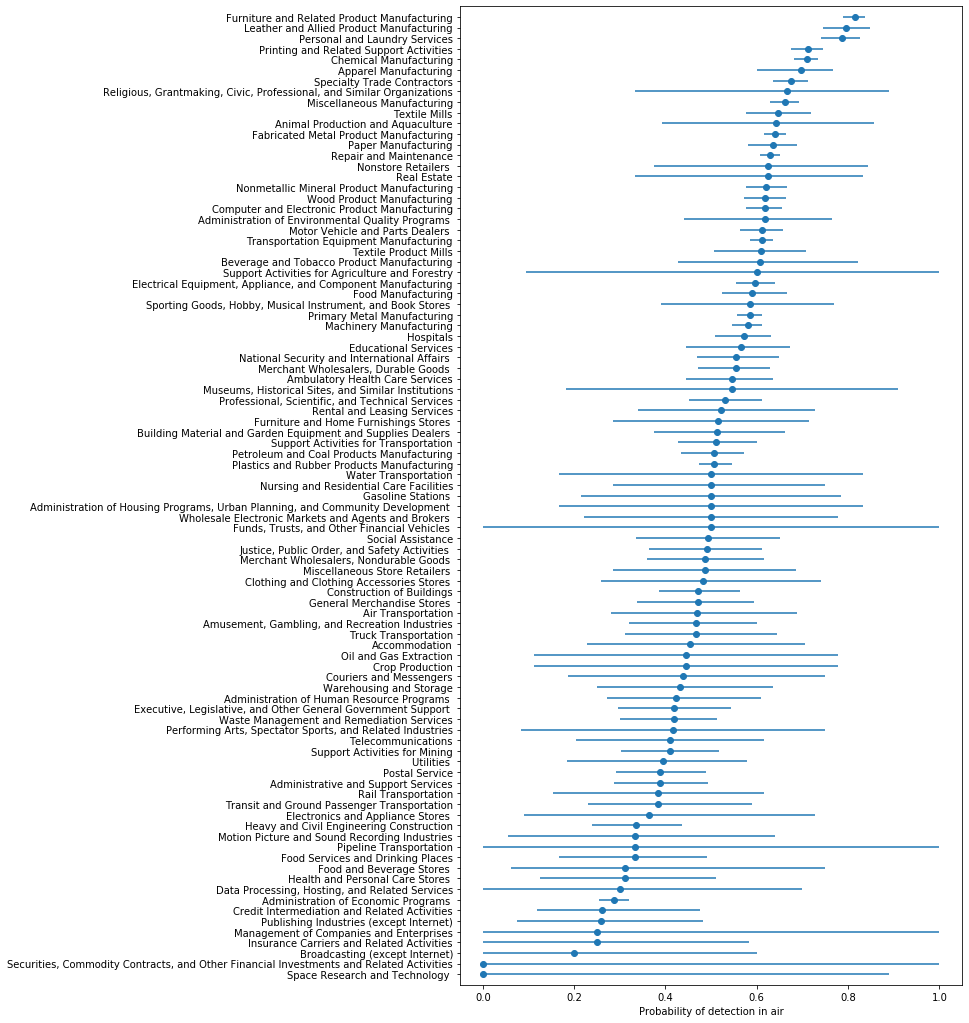

In [363]:
error_95_upper = (subsector_95h-subsector_median).loc[subsector_order.index]
error_95_lower = (subsector_median-subsector_95l).loc[subsector_order.index]
plt.figure(figsize=(9,18))
plt.errorbar(x=subsector_median.loc[subsector_order.index], y=subsector_order.index,
             xerr=(error_95_lower, error_95_upper),
            fmt='o')
plt.ylim(-1,91)
plt.xlabel("Probability of detection in air")
plt.show()